In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [40]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from  datetime import datetime,timedelta

In [41]:
def random_date(start, end):
    """startとendの差をday変換してランダムで選択して、startに加算"""
    delta = end - start
    int_delta = (delta.days)
    random_day = random.randrange(int_delta)
    return (start + timedelta(days=random_day)).strftime("%Y-%m-%d")

In [42]:
start_day = datetime.strptime('2018-01-01', '%Y-%m-%d')
end_day = datetime.strptime('2018-06-01', '%Y-%m-%d')
print(random_date(start_day, end_day))

2018-03-13


In [43]:
def random_id(n_size):
    return random.choice(range(n_size))

In [44]:
print(random_id(10))

4


In [45]:
def create_dataset(d_length, n_size, start_day, end_day):
    """ datasetをつくる
    customer_id: user
    event_date: action(ログイン、logなどなにかしらの行動が発生した日)
    weekofyear: event_dateがその年の何週目にあたるか
    """
    d_list = []
    for _ in range(d_length):
        d_list.append([random_id(n_size),random_date(start_day, end_day)])
    # dataframeに変換
    df = pd.DataFrame(d_list, columns=["customer_id","event_date"])
    # event_dateがその年の何週目にあたるのかを算出
    df["weekofyear"] = pd.to_datetime(df["event_date"]).dt.weekofyear
    
    return df

In [46]:
d1 = datetime.strptime('2018-01-01', '%Y-%m-%d')
d2 = datetime.strptime('2018-06-01', '%Y-%m-%d')
df =create_dataset(20000, n_size=1000, start_day=d1, end_day=d2)
df.head()

,customer_id,event_date,weekofyear
0,550,2018-03-19,12
1,579,2018-03-30,13
2,359,2018-01-29,5
3,74,2018-04-05,14
4,11,2018-02-14,7


In [47]:
# それぞれのcustomer_idが一番最初にeventを行った日を参照する
df.groupby("customer_id")["event_date"].min().head()

customer_id
0    2018-01-08
1    2018-01-06
2    2018-01-01
3    2018-01-03
4    2018-01-07
Name: event_date, dtype: object

In [48]:
# dfにmergeさせる
df=df.merge(df.groupby("customer_id")["event_date"].min().reset_index(),on="customer_id",suffixes=("","_init") ,how="left")
df.head()

,customer_id,event_date,weekofyear,event_date_init
0,550,2018-03-19,12,2018-01-13
1,579,2018-03-30,13,2018-01-13
2,359,2018-01-29,5,2018-01-11
3,74,2018-04-05,14,2018-01-07
4,11,2018-02-14,7,2018-01-09


In [49]:
# 初回のイベント日についてもweekodyearを計算
df["weekofyear_init"] = pd.to_datetime(df["event_date_init"]).dt.weekofyear
df.head()

,customer_id,event_date,weekofyear,event_date_init,weekofyear_init
0,550,2018-03-19,12,2018-01-13,2
1,579,2018-03-30,13,2018-01-13,2
2,359,2018-01-29,5,2018-01-11,2
3,74,2018-04-05,14,2018-01-07,1
4,11,2018-02-14,7,2018-01-09,2


In [50]:
# 初回のイベント、イベント発生日ごとでidを集計　今回は重複が含まれているため、nuniqueを使用
df.groupby(["weekofyear_init","weekofyear"])["customer_id"].nunique().head(10)

weekofyear_init  weekofyear
1                1             586
                 2             366
                 3             352
                 4             358
                 5             349
                 6             369
                 7             360
                 8             359
                 9             376
                 10            344
Name: customer_id, dtype: int64

In [51]:
gp = df.groupby(["weekofyear_init","weekofyear"])["customer_id"].nunique()
gp=gp.reset_index()
gp.head()

,weekofyear_init,weekofyear,customer_id
0,1,1,586
1,1,2,366
2,1,3,352
3,1,4,358
4,1,5,349


In [52]:
# weekofyear_init(初回イベント発生日)から見て、それぞれのイベントが何周目後に発生したものかを集計
gp["cohort_group"] = gp["weekofyear"] - gp["weekofyear_init"] + 1
gp.head()

,weekofyear_init,weekofyear,customer_id,cohort_group
0,1,1,586,1
1,1,2,366,2
2,1,3,352,3
3,1,4,358,4
4,1,5,349,5


In [53]:
user_retention=gp.pivot_table(values="customer_id",columns="cohort_group",index="weekofyear_init")

In [54]:
user_retention.head(20)

cohort_group,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
weekofyear_init,,,,,,,,,,,,,,,,,,,,,,
1,586.0,366.0,352.0,358.0,349.0,369.0,360.0,359.0,376.0,344.0,351.0,372.0,352.0,357.0,380.0,352.0,357.0,348.0,364.0,357.0,358.0,233.0
2,256.0,157.0,156.0,156.0,157.0,143.0,153.0,146.0,156.0,161.0,156.0,154.0,153.0,163.0,152.0,155.0,157.0,159.0,148.0,156.0,122.0,NaN
3,87.0,62.0,51.0,53.0,53.0,48.0,56.0,53.0,44.0,52.0,60.0,59.0,45.0,51.0,55.0,53.0,53.0,61.0,62.0,31.0,NaN,NaN
4,41.0,27.0,19.0,26.0,21.0,22.0,21.0,21.0,23.0,22.0,22.0,21.0,24.0,22.0,19.0,20.0,22.0,26.0,13.0,NaN,NaN,NaN
5,14.0,9.0,5.0,5.0,7.0,5.0,8.0,7.0,5.0,4.0,8.0,7.0,11.0,10.0,6.0,10.0,9.0,11.0,NaN,NaN,NaN,NaN
6,7.0,5.0,3.0,2.0,4.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,1.0,2.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN
7,5.0,4.0,3.0,2.0,2.0,4.0,1.0,2.0,3.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,3.0,1.0,1.0,3.0,2.0,3.0,2.0,3.0,1.0,2.0,4.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# それぞれのイベント初日のユーザー数（母数）を取得
user_number = user_retention.iloc[:,0].values
print(user_number)

[586. 256.  87.  41.  14.   7.   5.   4.]


In [68]:
# それぞれのイベント初日のユーザー数（母数）を取得し、母数に対して、各イベント期間にどれだけユーザーが残っていたのかを計算
user_retention = user_retention.apply(lambda x : x / x.iloc[0],axis=1)

In [69]:
user_retention.head()

cohort_group,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
weekofyear_init,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.624573,0.600683,0.610922,0.595563,0.629693,0.614334,0.612628,0.641638,0.587031,0.598976,0.634812,0.600683,0.609215,0.648464,0.600683,0.609215,0.593857,0.621160,0.609215,0.610922,0.397611
2,1.0,0.613281,0.609375,0.609375,0.613281,0.558594,0.597656,0.570312,0.609375,0.628906,0.609375,0.601562,0.597656,0.636719,0.593750,0.605469,0.613281,0.621094,0.578125,0.609375,0.476562,NaN
3,1.0,0.712644,0.586207,0.609195,0.609195,0.551724,0.643678,0.609195,0.505747,0.597701,0.689655,0.678161,0.517241,0.586207,0.632184,0.609195,0.609195,0.701149,0.712644,0.356322,NaN,NaN
4,1.0,0.658537,0.463415,0.634146,0.512195,0.536585,0.512195,0.512195,0.560976,0.536585,0.536585,0.512195,0.585366,0.536585,0.463415,0.487805,0.536585,0.634146,0.317073,NaN,NaN,NaN
5,1.0,0.642857,0.357143,0.357143,0.500000,0.357143,0.571429,0.500000,0.357143,0.285714,0.571429,0.500000,0.785714,0.714286,0.428571,0.714286,0.642857,0.785714,NaN,NaN,NaN,NaN


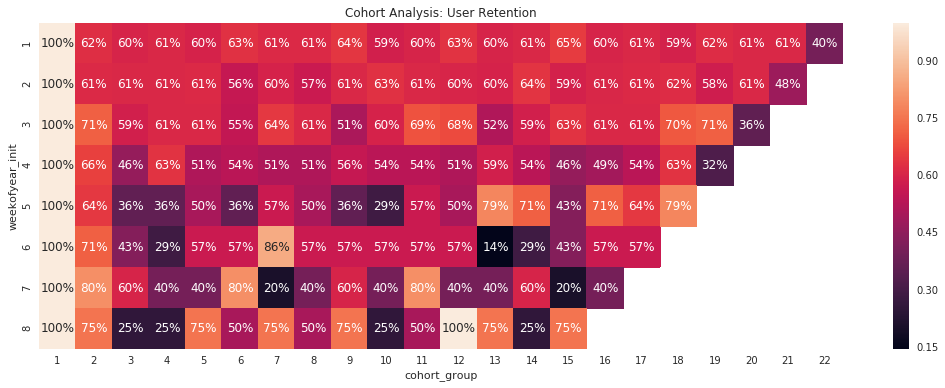

In [71]:
plt.figure(figsize=(18, 6))
plt.title('Cohort Analysis: User Retention')
sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt='.0%')